<a href="https://colab.research.google.com/github/ljrn8/quick-notebooks/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP3010 Machine Learning Assignment | 20757218 Joel Hoefs


## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sklearn

!pip install -U numpy
!pip install -U optuna
!curl -LJO https://raw.githubusercontent.com/qilinli/COMP3010-Machine-Learning/refs/heads/master/2025-assignment/train.csv
!curl -LJO https://raw.githubusercontent.com/qilinli/COMP3010-Machine-Learning/refs/heads/master/2025-assignment/test.csv

files = os.listdir('.')
assert 'test.csv' in files
assert 'train.csv' in files
print(files)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 63.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 16.0 MB/s eta 0:00:00
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1186k  100

In [2]:
df = pd.read_csv('train.csv', index_col=False).drop('Unnamed: 0', axis=1)      # train/validation
test_df = pd.read_csv('test.csv', index_col=False).drop('Unnamed: 0', axis=1)  # test
len(df), len(test_df)

(10050, 3203)

In [3]:
df.columns

Index(['Tank Failure Pressure (bar)', 'Liquid Ratio', 'Tank Width (m)',
       'Tank Length (m)', 'Tank Height (m)', 'BLEVE Height (m)',
       'Vapour Height (m)', 'Vapour Temperature (K)', 'Liquid Temperature (K)',
       'Obstacle Distance to BLEVE (m)', 'Obstacle Width (m)',
       'Obstacle Height (m)', 'Obstacle Thickness (m)', 'Obstacle Angle',
       'Status', 'Liquid Critical Pressure (bar)',
       'Liquid Boiling Temperature (K)', 'Liquid Critical Temperature (K)',
       'Sensor ID', 'Sensor Position Side', 'Sensor Position x',
       'Sensor Position y', 'Sensor Position z', 'Target Pressure (bar)'],
      dtype='object')

## Preprocessing


In [4]:
# observe categorical columns
categorical = ['Status', 'Sensor Position Side', 'Sensor ID']
for c in categorical:
  print(c,  ' unique values: ')
  print(np.unique(list(df[c])))
  print()

Status  unique values: 
['Saperheated' 'Subcoled' 'Subcool' 'Subcooled' 'Superheat' 'Superheated'
 'nan' 'subcooled' 'superheated']

Sensor Position Side  unique values: 
[ 1.  2.  3.  4.  5. nan]

Sensor ID  unique values: 
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. nan]



In [5]:
# Fix invalid 'status' entries and dtype conversion
def status_map(name):
  if name in ['Saperheated', 'Superheat', 'Superheated', 'superheated']:
    return 1
  else:
    return 0

df['Status'] = df['Status'].map(status_map)
test_df['Status'] = test_df['Status'].map(status_map)
np.unique(df['Status'])

array([0, 1])

In [6]:
# observe NaN entries
for c in df.columns:
  print(f'NaN entries in [{c}]: ', pd.isna(df[c]).sum())

NaN entries in [Tank Failure Pressure (bar)]:  10
NaN entries in [Liquid Ratio]:  9
NaN entries in [Tank Width (m)]:  7
NaN entries in [Tank Length (m)]:  5
NaN entries in [Tank Height (m)]:  8
NaN entries in [BLEVE Height (m)]:  10
NaN entries in [Vapour Height (m)]:  9
NaN entries in [Vapour Temperature (K)]:  28
NaN entries in [Liquid Temperature (K)]:  28
NaN entries in [Obstacle Distance to BLEVE (m)]:  8
NaN entries in [Obstacle Width (m)]:  8
NaN entries in [Obstacle Height (m)]:  8
NaN entries in [Obstacle Thickness (m)]:  8
NaN entries in [Obstacle Angle]:  8
NaN entries in [Status]:  0
NaN entries in [Liquid Critical Pressure (bar)]:  28
NaN entries in [Liquid Boiling Temperature (K)]:  27
NaN entries in [Liquid Critical Temperature (K)]:  29
NaN entries in [Sensor ID]:  8
NaN entries in [Sensor Position Side]:  10
NaN entries in [Sensor Position x]:  7
NaN entries in [Sensor Position y]:  9
NaN entries in [Sensor Position z]:  7
NaN entries in [Target Pressure (bar)]:  6


NaN entries are somewhat evenly distributed, but are abundant. Thus I'll
 choose imputation over deletion, but only for the non-categorical columns.

In [7]:
# fill nan entries with median imputation
df = df.fillna(df.median(numeric_only=True))

# dont impute categorical columns
df = df[(~pd.isna(df[categorical])).all(axis=1)]

assert pd.isna(df).all(axis=1).sum() == 0
df[:3]

,Tank Failure Pressure (bar),Liquid Ratio,Tank Width (m),Tank Length (m),Tank Height (m),BLEVE Height (m),Vapour Height (m),Vapour Temperature (K),Liquid Temperature (K),Obstacle Distance to BLEVE (m),...,Status,Liquid Critical Pressure (bar),Liquid Boiling Temperature (K),Liquid Critical Temperature (K),Sensor ID,Sensor Position Side,Sensor Position x,Sensor Position y,Sensor Position z,Target Pressure (bar)
0,14.26,0.25,1.58,8.61,1.79,1.01,1.40,457.14,423.07,19.0,...,1,37.9,-1.0,152.0,18.0,2.0,19.75,5.70,3.1,0.588298
1,14.14,0.25,1.59,8.58,1.81,1.00,1.41,457.71,422.82,19.0,...,1,37.9,-1.0,152.0,19.0,3.0,20.00,-5.15,-1.5,0.551524
2,14.05,0.24,1.62,8.59,1.79,0.98,1.38,456.58,422.37,19.0,...,1,37.9,-1.0,152.0,20.0,3.0,20.00,-5.15,0.8,0.550813


In [8]:
# outlier detection and imputation
def impute_outliers(df, columns, z):
  for c in columns:
    median = df[c].median()
    threshold = z * df[c].std()
    is_outlier = np.abs(df[c] - median) > threshold
    print(f'outliers in [{c}]: {is_outlier.sum()}')
    df[c] = np.where(is_outlier, median, df[c])

cols = df.drop(categorical, axis=1).columns
impute_outliers(df, z=3.5, columns=cols)

outliers in [Tank Failure Pressure (bar)]: 50
outliers in [Liquid Ratio]: 0
outliers in [Tank Width (m)]: 0
outliers in [Tank Length (m)]: 0
outliers in [Tank Height (m)]: 0
outliers in [BLEVE Height (m)]: 0
outliers in [Vapour Height (m)]: 0
outliers in [Vapour Temperature (K)]: 0
outliers in [Liquid Temperature (K)]: 0
outliers in [Obstacle Distance to BLEVE (m)]: 0
outliers in [Obstacle Width (m)]: 0
outliers in [Obstacle Height (m)]: 0
outliers in [Obstacle Thickness (m)]: 0
outliers in [Obstacle Angle]: 0
outliers in [Liquid Critical Pressure (bar)]: 0
outliers in [Liquid Boiling Temperature (K)]: 0
outliers in [Liquid Critical Temperature (K)]: 0
outliers in [Sensor Position x]: 0
outliers in [Sensor Position y]: 10
outliers in [Sensor Position z]: 0
outliers in [Target Pressure (bar)]: 161


In [9]:
# 1 hot encodings for sensor ID and Sensor position side columns:
for df_ in [df, test_df]:
    df_['Sensor ID'] = pd.Categorical(df_['Sensor ID'])
    df_['Sensor Position Side'] = pd.Categorical(df_['Sensor Position Side'])

df = pd.get_dummies(df, columns=['Sensor ID', 'Sensor Position Side'])
test_df = pd.get_dummies(test_df, columns=['Sensor ID', 'Sensor Position Side'])

test_df.columns

Index(['Tank Failure Pressure (bar)', 'Liquid Ratio', 'Tank Width (m)',
       'Tank Length (m)', 'Tank Height (m)', 'BLEVE Height (m)',
       'Vapour Height (m)', 'Vapour Temperature (K)', 'Liquid Temperature (K)',
       'Obstacle Distance to BLEVE (m)', 'Obstacle Width (m)',
       'Obstacle Height (m)', 'Obstacle Thickness (m)', 'Obstacle Angle',
       'Status', 'Liquid Critical Pressure (bar)',
       'Liquid Boiling Temperature (K)', 'Liquid Critical Temperature (K)',
       'Sensor Position x', 'Sensor Position y', 'Sensor Position z',
       'Sensor ID_1', 'Sensor ID_2', 'Sensor ID_3', 'Sensor ID_4',
       'Sensor ID_5', 'Sensor ID_6', 'Sensor ID_7', 'Sensor ID_8',
       'Sensor ID_9', 'Sensor ID_10', 'Sensor ID_11', 'Sensor ID_12',
       'Sensor ID_13', 'Sensor ID_14', 'Sensor ID_15', 'Sensor ID_16',
       'Sensor ID_17', 'Sensor ID_18', 'Sensor ID_19', 'Sensor ID_20',
       'Sensor ID_21', 'Sensor ID_22', 'Sensor ID_23', 'Sensor ID_24',
       'Sensor ID_25', 'Sensor I

In [10]:
# drop duplicates
print(len(df))
df = df.drop_duplicates()
print(len(df))

10050
10000


In [11]:
# remove invalid entries
def filter_range(df, c, ub, lb):
  df_filtered = df[(df[c] >= lb) & (df[c] <= ub)]
  n_filtered =  len(df) - len(df_filtered)
  print(f'number of out-of-bounds [{c}] instances = {n_filtered}')
  return df_filtered

# rational metric upperbound for Kelvin/metres
UB = 1_000

filter_range_map = {
  'Tank Failure Pressure (bar)': (0, np.inf),
  'Liquid Ratio': (0, 1),
  'Tank Width (m)': (0, UB),
  'Tank Length (m)': (0, UB),
  'Tank Height (m)': (0, UB),
  'Vapour Height (m)': (0, UB),
  'BLEVE Height (m)': (0, UB),
  'Vapour Temperature (K)': (0, np.inf),
  'Liquid Temperature (K)': (0, UB),
  'Obstacle Distance to BLEVE (m)': (0, UB),
  'Obstacle Width (m)': (0, UB),
  'Obstacle Height (m)': (0, UB),
  'Obstacle Thickness (m)': (0, UB),
  'Obstacle Angle': (0, 30),
  'Sensor Position x': (-UB, UB),
  'Sensor Position y': (-UB, UB),
  'Sensor Position z': (-UB, UB),
  'Target Pressure (bar)': (0, np.inf),
}

df_interm = df.copy()
for column, (lb, ub) in filter_range_map.items():
  train_interm = filter_range(df_interm, column, ub, lb)

number of out-of-bounds [Tank Failure Pressure (bar)] instances = 0
number of out-of-bounds [Liquid Ratio] instances = 0
number of out-of-bounds [Tank Width (m)] instances = 0
number of out-of-bounds [Tank Length (m)] instances = 0
number of out-of-bounds [Tank Height (m)] instances = 0
number of out-of-bounds [Vapour Height (m)] instances = 0
number of out-of-bounds [BLEVE Height (m)] instances = 157
number of out-of-bounds [Vapour Temperature (K)] instances = 0
number of out-of-bounds [Liquid Temperature (K)] instances = 0
number of out-of-bounds [Obstacle Distance to BLEVE (m)] instances = 0
number of out-of-bounds [Obstacle Width (m)] instances = 0
number of out-of-bounds [Obstacle Height (m)] instances = 0
number of out-of-bounds [Obstacle Thickness (m)] instances = 0
number of out-of-bounds [Obstacle Angle] instances = 0
number of out-of-bounds [Sensor Position x] instances = 0
number of out-of-bounds [Sensor Position y] instances = 0
number of out-of-bounds [Sensor Position z] i

(-0.05, 0.3)

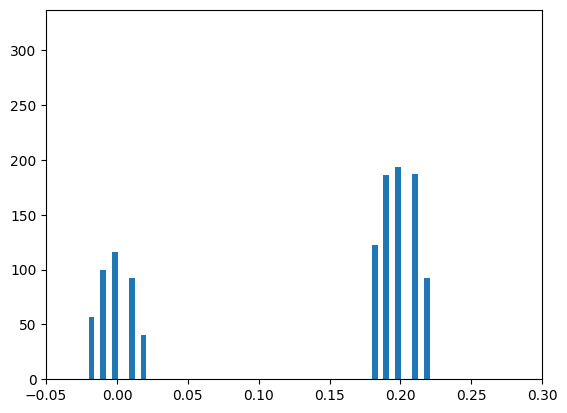

In [12]:
plt.hist(df['BLEVE Height (m)'], bins=500)
plt.xlim(-0.05, 0.3)

In [13]:
# some BLEVE Height (m) measurements were negative, so I'll just round them up
df['BLEVE Height (m)'] = df['BLEVE Height (m)'].map(lambda x: max(x, 0))

In [14]:
# Feature Engineering:
for data in (df, test_df):

  # Dimension Ratio's
  data['Tank width/length Ratio'] = data['Tank Width (m)'] / data['Tank Length (m)']
  data['Tank width/height Ratio'] =  data['Tank Width (m)'] / data['Tank Height (m)']

  # precise distance to sensor
  sensor_offsets = np.sqrt(data['Sensor Position x']**2 + data['Sensor Position y']**2 + data['Sensor Position z']**2)
  data['Sensor-Obstacle Distance'] = data['Obstacle Distance to BLEVE (m)'] + sensor_offsets

## Feature Selection

Feature Selection done with permutation importance using XGBoost

In [37]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.inspection import permutation_importance

X, y = df.drop('Target Pressure (bar)', axis=1), df['Target Pressure (bar)']
X_train, X_val, y_train, y_val = train_test_split(X, y , test_size=0.2)

model = xgb.XGBRegressor().fit(X_train, y_train)
model.score(X_val, y_val)

r = permutation_importance(model, X_val, y_val,
                           n_repeats=50,
                           random_state=0)

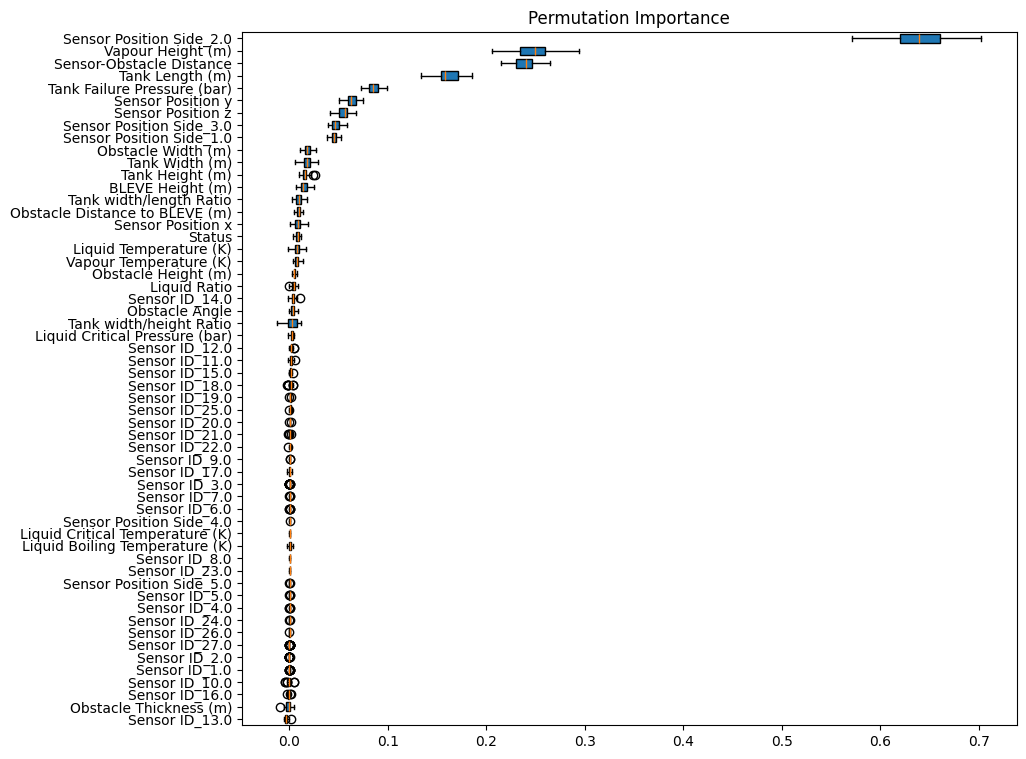

In [38]:
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'mean': [np.mean(r.importances[i]) for i in range(len(X.columns))],
    'dist': [r.importances[i] for i in range(len(X.columns))],
}).sort_values(by='mean')

plt.figure(figsize=(10, 9))

plt.boxplot(importance_df['dist'].values, vert=False, patch_artist=True, widths=0.7)

plt.yticks(range(1, len(importance_df) + 1), importance_df['Feature'])
plt.title('Permutation Importance')

plt.show()

In [39]:
# Remove bottom 3 features
def permutation_filter(df, remove_features):
  cols_ordered = list(importance_df['Feature'])
  if 'Unnamed: 0' in df.columns: cols_ordered.remove('Unnamed: 0')
  cols = list(cols_ordered[remove_features:])
  return df[cols]

alternatively, I consider using PCA for 20 components

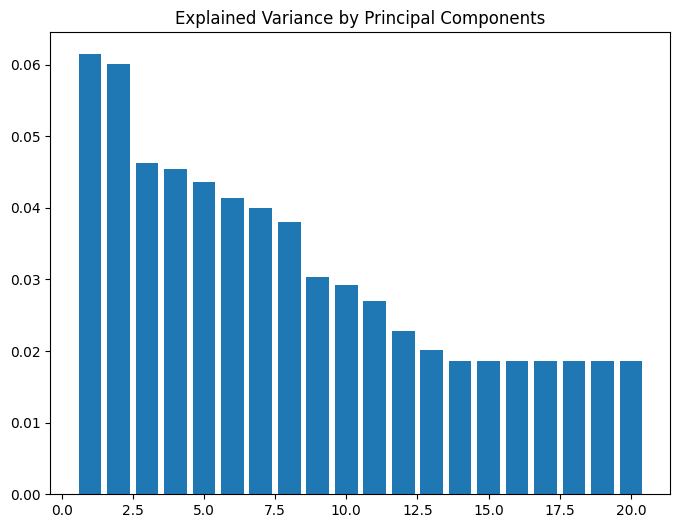

In [40]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X, y = df.drop('Target Pressure (bar)', axis=1), df['Target Pressure (bar)']
scaler = StandardScaler()

pca = PCA(n_components=20)
X_scaled = scaler.fit_transform(X)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.title('Explained Variance by Principal Components')
plt.show()

## Model Developement

In [42]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

df = df.drop('Unnamed: 0', axis=1, errors='ignore')
X, y =  df.drop('Target Pressure (bar)', axis=1), df['Target Pressure (bar)']

# dataset based on permutation importance selection
X_pfi = permutation_filter(X, remove_features=3)

# dataset based on PCA features
pca = PCA(n_components=17)
X_scaled = scaler.fit_transform(X)
X_pca = pca.fit_transform(X_scaled)

# CV evulations for R2 and MAPE
def evaluate_cv(model, X, y, cv=4):
  r2_scores = cross_validate(model, X, y, cv=cv, scoring='r2')['test_score']
  mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
  mape_scores = cross_validate(model, X, y, cv=cv, scoring=mape_scorer)['test_score']
  return {
      "R2_mean": np.mean(r2_scores),
      "R2_std": np.std(r2_scores),
      "MAPE_mean": -np.mean(mape_scores),
      "MAPE_std": np.std(mape_scores),
  }


#### Model Selection

In [43]:
scores = []

for X, dataset in ((X_pfi, 'Permutation importance'),
                   (X_pca, 'PCA')):

  for (model, name) in ((xgb.XGBRegressor(), 'XGboost'),
                        (RandomForestRegressor(), 'RF'),
                        (SVR(), 'SVM'),
                        (LinearRegression(), 'LR')):

    pipe = Pipeline([('scaler', StandardScaler()), (name, model)])
    m = evaluate_cv(model=pipe, X=X, y=y, cv=5)
    scores.append((dataset + ' & ' + name, m))

scores

[('Permutation importance & XGboost',
  {'R2_mean': np.float64(0.6469000027383152),
   'R2_std': np.float64(0.043936677316926805),
   'MAPE_mean': np.float64(0.4300917089016334),
   'MAPE_std': np.float64(0.022416181044167864)}),
 ('Permutation importance & RF',
  {'R2_mean': np.float64(0.6333400276146958),
   'R2_std': np.float64(0.04618870911187238),
   'MAPE_mean': np.float64(0.4216584577982389),
   'MAPE_std': np.float64(0.01971288608154072)}),
 ('Permutation importance & SVM',
  {'R2_mean': np.float64(0.6837272378332664),
   'R2_std': np.float64(0.07059796037531495),
   'MAPE_mean': np.float64(0.5166130618873459),
   'MAPE_std': np.float64(0.046694603499032275)}),
 ('Permutation importance & LR',
  {'R2_mean': np.float64(0.593296128548886),
   'R2_std': np.float64(0.03152547314524772),
   'MAPE_mean': np.float64(0.7524204063440971),
   'MAPE_std': np.float64(0.05778899573152956)}),
 ('PCA & XGboost',
  {'R2_mean': np.float64(0.5123325466922827),
   'R2_std': np.float64(0.020535223

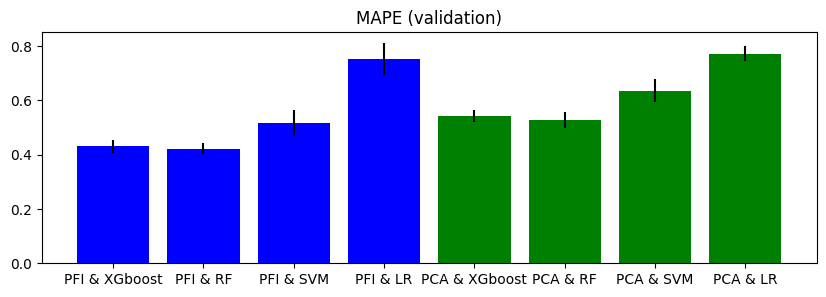

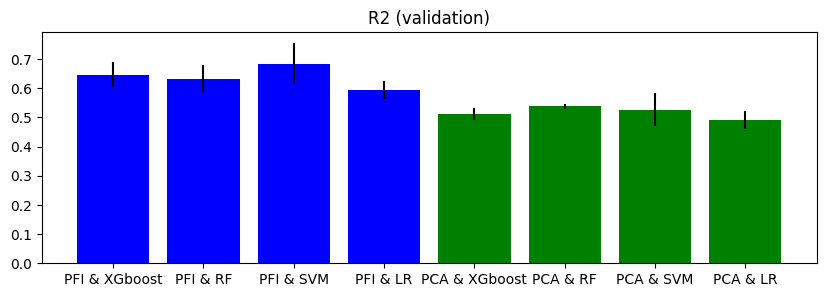

In [55]:
for metric in ('MAPE', 'R2'):
  fig, ax = plt.subplots(figsize=(10, 3))
  for name, scores_dict in scores:
    if not name.startswith('PCA'):
      name = 'PFI'  + name[len('Permutation Importance'):]

    plt.title(metric + ' (validation)')
    c = 'green' if name.startswith('PCA') else 'blue'
    plt.bar(name, scores_dict[f'{metric}_mean'], yerr=scores_dict[f'{metric}_std'], color=c)

  plt.show()


* Permutation importance did better than PCA
* SVM & LR underperformed
* All methods overfit significantly

*MLP* performed best without tuning

### XGBoost

In [31]:
!pip install optuna cmaes

In [57]:
import optuna
import cmaes
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_percentage_error, make_scorer

df = df.drop('Unnamed: 0', axis=1, errors='ignore')
X, y =  df.drop('Target Pressure (bar)', axis=1), df['Target Pressure (bar)']
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=0)


def objective(trial):
  params = {
      "verbosity": 0,
      "objective": "reg:squarederror",
      "eval_metric": "rmse",
      "booster": "gbtree",
      "max_depth": trial.suggest_int("max_depth", 3, 10),
      "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.5, log=True),
      "subsample": trial.suggest_float("subsample", 0.5, 1.0),
      "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
      "gamma": trial.suggest_float("gamma", 0, 5),
      "lambda": trial.suggest_float("lambda", 1e-3, 10.0, log=True),
      "alpha": trial.suggest_float("alpha", 1e-3, 10.0, log=True),
      "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
  }

  model = xgb.XGBRegressor(**params)
  # scores = cross_val_score(model, X, y, cv=4, scoring=mape_scorer)
  model.fit(X_train, y_train)
  score =  mean_absolute_percentage_error(model.predict(X_val), y_val)
  return score

cmaes_sampler = optuna.samplers.CmaEsSampler()
study = optuna.create_study(direction="minimize", sampler=cmaes_sampler)
study.optimize(objective, n_trials=100)

print("Best hyperparameters:", study.best_params)
print(study.best_trial)

[I 2025-04-29 12:54:31,825] A new study created in memory with name: no-name-53e3adaa-e00e-46f7-908a-45f770926675
[I 2025-04-29 12:54:38,636] Trial 0 finished with value: 0.3162909645858352 and parameters: {'max_depth': 10, 'learning_rate': 0.010133699900638159, 'subsample': 0.8432488040298143, 'colsample_bytree': 0.6628320682371436, 'gamma': 2.194196344748127, 'lambda': 0.8406024975786448, 'alpha': 0.07284456854867025, 'n_estimators': 1797}. Best is trial 0 with value: 0.3162909645858352.
[I 2025-04-29 12:54:40,476] Trial 1 finished with value: 0.30233847526922225 and parameters: {'max_depth': 8, 'learning_rate': 0.0817002373493146, 'subsample': 0.8070303510503241, 'colsample_bytree': 0.6794547415764386, 'gamma': 1.7837061462665404, 'lambda': 0.12205112155896572, 'alpha': 0.15059688803325175, 'n_estimators': 1167}. Best is trial 1 with value: 0.30233847526922225.
[I 2025-04-29 12:54:41,243] Trial 2 finished with value: 0.3196724295562469 and parameters: {'max_depth': 5, 'learning_rate

Best hyperparameters: {'max_depth': 9, 'learning_rate': 0.00652890649837957, 'subsample': 0.6445245525276786, 'colsample_bytree': 0.7844359628738031, 'gamma': 0.04392675077041788, 'lambda': 0.5968915873856662, 'alpha': 0.015571252745348287, 'n_estimators': 1634}
FrozenTrial(number=94, state=1, values=[0.1821316060878947], datetime_start=datetime.datetime(2025, 4, 29, 12, 57, 37, 784908), datetime_complete=datetime.datetime(2025, 4, 29, 12, 57, 49, 207902), params={'max_depth': 9, 'learning_rate': 0.00652890649837957, 'subsample': 0.6445245525276786, 'colsample_bytree': 0.7844359628738031, 'gamma': 0.04392675077041788, 'lambda': 0.5968915873856662, 'alpha': 0.015571252745348287, 'n_estimators': 1634}, user_attrs={}, system_attrs={'cma:generation': 9, 'cma:popsize': 10, 'cma:n_restarts': 0, 'cma:n_restarts_with_large': 0, 'cma:poptype': 'small', 'cma:small_n_eval': 0, 'cma:large_n_eval': 0}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=10, log=False, low=3, st

### Random Forest

In [192]:
from sklearn.model_selection import GridSearchCV

X_train, X_val, y_train, y_val = train_test_split(
      X, y, test_size=0.2, random_state=0)

def objective(trail):
  params = {
      'n_estimators': trail.suggest_int('n_estimatos', 20, 300),
      'max_depth': trail.suggest_int('max_depth', 10, 50),
      'min_samples_leaf': trail.suggest_int('min_samples_leaf', 1, 5)
  }
  model = RandomForestRegressor(**params)
  model.fit(X_train, y_train)
  score =  mean_absolute_percentage_error(model.predict(X_val), y_val)
  return score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best hyperparameters:", study.best_params)
print(study.best_trial)

[I 2025-04-29 08:49:25,789] A new study created in memory with name: no-name-85ae81fc-2169-4840-a936-647cd0a6eb84
[I 2025-04-29 08:50:07,816] Trial 0 finished with value: 0.19320476776081058 and parameters: {'n_estimatos': 236, 'max_depth': 39, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.19320476776081058.
[I 2025-04-29 08:50:22,398] Trial 1 finished with value: 0.21125128342143437 and parameters: {'n_estimatos': 130, 'max_depth': 45, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.19320476776081058.
[I 2025-04-29 08:50:36,168] Trial 2 finished with value: 0.21081881755098364 and parameters: {'n_estimatos': 124, 'max_depth': 34, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.19320476776081058.
[I 2025-04-29 08:50:54,579] Trial 3 finished with value: 0.19372589686496114 and parameters: {'n_estimatos': 116, 'max_depth': 19, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.19320476776081058.
[I 2025-04-29 08:51:02,575] Trial 4 finished with value: 0.20801169078

Best hyperparameters: {'n_estimatos': 300, 'max_depth': 38, 'min_samples_leaf': 1}


### Nueral Network

In [180]:
import torch.optim as optim
import torch
from torch.utils.data import TensorDataset

scaler = StandardScaler()
X, y =  df.drop('Target Pressure (bar)', axis=1), df['Target Pressure (bar)']
X_test = np.array(test_df.drop('Unnamed: 0', axis=1, errors='ignore'))

# fit scaler to both test and training
scaler.fit(X)
X_labelled_nn = scaler.transform(X)
X_test_scaled = scaler.transform(X_test)

# convert to torch tensors
X_test_nn = torch.tensor(X_test_scaled, dtype=torch.float32)
X_train, X_val, y_train, y_val = train_test_split(
    X_labelled_nn.astype(np.float32),
    np.array(y).astype(np.float32).reshape(-1, 1), test_size=0.2)

train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [185]:
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_percentage_error

import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np


class NN(nn.Module):
  def __init__(self, input_size, hidden_layers):
    super(NN, self).__init__()
    layers = []
    layers.append(nn.Linear(input_size, hidden_layers[0]))
    layers.append(nn.ReLU())

    for i in range(1, len(hidden_layers)):
      layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
      layers.append(nn.ReLU())

    layers.append(nn.Linear(hidden_layers[-1], 1))
    self.model = nn.Sequential(*layers)

  def forward(self, x):
    return self.model(x)


class EarlyStopper:
  def __init__(self, patience=10, delta=1e-5):
    self.patience = patience
    self.delta = delta
    self.counter = 0
    self.best_score = None
    self.early_stop = False

  def check(self, model, val_loader):
    current_score = evaluate(model, val_loader)
    if self.best_score is None or current_score < self.best_score - self.delta:
      self.best_score = current_score
      self.counter = 0
    else:
      self.counter += 1

    if self.counter >= self.patience:
      self.early_stop = True

    return self.early_stop, current_score


def evaluate(model, data_loader):
  model.eval()
  all_preds, all_targets = [], []
  with torch.no_grad():
    for xb, yb in data_loader:
      preds = model(xb)
      all_preds.append(preds.numpy())
      all_targets.append(yb.numpy())

  all_preds = np.vstack(all_preds)
  all_targets = np.vstack(all_targets)
  return mean_absolute_percentage_error(all_targets, all_preds)


def train(model, train_loader, val_loader,
          epochs, lr, early_stopper=None):

  mape_scores = []
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=lr)

  for epoch in range(epochs):
    model.train()
    for xb, yb in train_loader:
      optimizer.zero_grad()
      preds = model(xb)
      loss = criterion(preds, yb)
      loss.backward()
      optimizer.step()

    if early_stopper:
      should_stop, epoch_mape = early_stopper.check(model, val_loader)
      mape_scores.append(epoch_mape)
      if should_stop:
        print(f"Early stopping ended training at epoch {epoch + 1}")
        break

  final_mape = evaluate(model, val_loader)
  return final_mape, mape_scores


def objective(trial):
  # hyperparameter search space
  n_layers = trial.suggest_int("n_layers", 2, 4)
  hidden_layers = [
      trial.suggest_int(f"hidden layer {i}", 16, 256)
      for i in range(n_layers)
  ]
  lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
  batch_size = trial.suggest_categorical("batch_size", [32, 64])
  model = NN(input_size=56, hidden_layers=hidden_layers)

  mape, each_mape = train(
      model,
      train_loader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
      val_loader=DataLoader(val_dataset, batch_size=batch_size, shuffle=False),
      epochs=30, # limited epochs for optimization
      lr=lr
  )
  return mape


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best trial:")
print(study.best_trial)

[I 2025-04-29 08:15:52,490] A new study created in memory with name: no-name-4afabd27-1561-4c4c-bb47-e3a0541f0290
[I 2025-04-29 08:16:02,547] Trial 0 finished with value: 0.3322831392288208 and parameters: {'n_layers': 2, 'hidden layer 0': 16, 'hidden layer 1': 200, 'lr': 0.0009557049356789547, 'batch_size': 64}. Best is trial 0 with value: 0.3322831392288208.
[I 2025-04-29 08:16:13,490] Trial 1 finished with value: 0.2443496137857437 and parameters: {'n_layers': 4, 'hidden layer 0': 31, 'hidden layer 1': 80, 'hidden layer 2': 150, 'hidden layer 3': 16, 'lr': 0.00299885649538166, 'batch_size': 64}. Best is trial 1 with value: 0.2443496137857437.
[I 2025-04-29 08:16:40,529] Trial 2 finished with value: 0.18839791417121887 and parameters: {'n_layers': 4, 'hidden layer 0': 134, 'hidden layer 1': 169, 'hidden layer 2': 247, 'hidden layer 3': 156, 'lr': 0.00036849183045986714, 'batch_size': 32}. Best is trial 2 with value: 0.18839791417121887.
[I 2025-04-29 08:16:54,912] Trial 3 finished wi

Best trial:
FrozenTrial(number=21, state=1, values=[0.1617375612258911], datetime_start=datetime.datetime(2025, 4, 29, 8, 22, 7, 861383), datetime_complete=datetime.datetime(2025, 4, 29, 8, 22, 40, 574909), params={'n_layers': 4, 'hidden layer 0': 231, 'hidden layer 1': 219, 'hidden layer 2': 174, 'hidden layer 3': 154, 'lr': 0.0006905040351981676, 'batch_size': 32}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_layers': IntDistribution(high=4, log=False, low=2, step=1), 'hidden layer 0': IntDistribution(high=256, log=False, low=16, step=1), 'hidden layer 1': IntDistribution(high=256, log=False, low=16, step=1), 'hidden layer 2': IntDistribution(high=256, log=False, low=16, step=1), 'hidden layer 3': IntDistribution(high=256, log=False, low=16, step=1), 'lr': FloatDistribution(high=0.01, log=True, low=0.0001, step=None), 'batch_size': CategoricalDistribution(choices=(32, 64))}, trial_id=21, value=None)


In [186]:
study.best_params

{'n_layers': 4,
 'hidden layer 0': 231,
 'hidden layer 1': 219,
 'hidden layer 2': 174,
 'hidden layer 3': 154,
 'lr': 0.0006905040351981676,
 'batch_size': 32}

## Final Evaluation

Early stopping ended training at epoch 172
validation MAPE:  0.15299952030181885


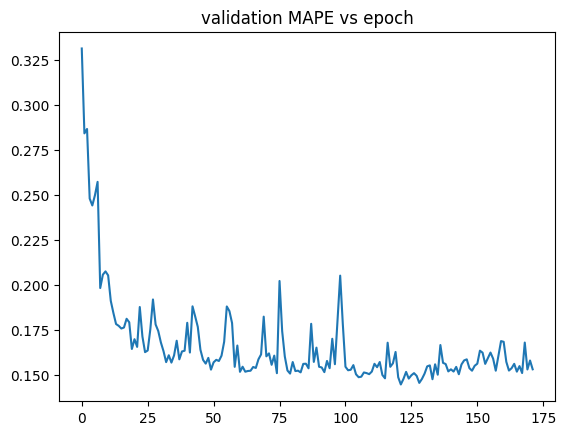

In [187]:
batch_size = 32
model = NN(hidden_layers=[231, 219, 174, 154], input_size=56)

mape, mape_scores = train(
    model,
    train_loader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    val_loader=DataLoader(val_dataset, batch_size=batch_size, shuffle=False),
    epochs=500,
    # relies on early stopping
    early_stopper=EarlyStopper(patience=50, delta=1e-5),
    lr=0.0006905040351981676,
)

print('validation MAPE: ', mape)
plt.plot(mape_scores)
plt.title('validation MAPE vs epoch')
plt.show()

In [188]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_nn).numpy()

y_pred

array([[0.11624733],
       [0.0904935 ],
       [0.10950652],
       ...,
       [0.6828732 ],
       [0.6253383 ],
       [0.6081658 ]], shape=(3203, 1), dtype=float32)

In [189]:
df = pd.DataFrame({
    'Target Pressure (bar)': y_pred.reshape(len(y_pred)),
    'ID': np.array(list(range(3203)))
})

In [190]:
df

,Target Pressure (bar),ID
0,0.116247,0
1,0.090494,1
2,0.109507,2
3,0.099341,3
4,0.088304,4
...,...,...
3198,0.802418,3198
3199,0.839750,3199
3200,0.682873,3200
3201,0.625338,3201


In [191]:
df.to_csv('y_pred.csv', index=False)